In [2]:
from tensorflow.keras.layers import Input, Embedding, Subtract, Concatenate, Flatten, Multiply, Dense
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

c:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Multiple-Input Models
We'll build a model which takes in three layers.

In [3]:
season_data = pd.read_csv('./data/games_season.csv')
print(season_data.head())

X_train, X_test, y_train, y_test = train_test_split(season_data[['team_1', 'team_2', 'home']], 
                                                    season_data['score_diff'], 
                                                    test_size=.3)

n_teams = pd.unique(season_data['team_1']).shape[0]
print(n_teams)

FileNotFoundError: [Errno 2] No such file or directory: './data/games_season.csv'

In [ ]:
input_tensor = Input(shape=(1, ))

teams_ratings = Embedding(
    input_dim=n_teams,
    output_dim=1,
    input_length=1,
    name='Team-Strength-Lookup'
)

embed_tensor = teams_ratings(input_tensor)
flatten_tensor = Flatten()(embed_tensor)
model = Model(input_tensor, flatten_tensor)


input_1 = Input(shape=(1, ))
input_2 = Input(shape=(1, ))
input_3 = Input(shape=(1, ))

output_tensor_1 = model(input_1)
output_tensor_2 = model(input_2)

concat_layer = Concatenate()([output_tensor_1, output_tensor_2, input_3])

out_layer = Dense(1)(concat_layer)

regular_season_model = Model([input_1, input_2, input_3], out_layer)

regular_season_model.compile(optimizer='adam', loss='mean_absolute_error')

In [ ]:
epochs = 10

history = regular_season_model.fit([X_train['team_1'], X_train['team_2'], 
                                    X_train['home']], 
                          y_train, 
                          batch_size=2048,
                          epochs=epochs, 
                          validation_split=.1)

Epoch 1/10
97/97 [==============================] - 2s 8ms/step - loss: 12.0383 - val_loss: 12.2050
Epoch 2/10
97/97 [==============================] - 0s 5ms/step - loss: 12.0198 - val_loss: 12.1854
Epoch 3/10
97/97 [==============================] - 0s 4ms/step - loss: 11.9948 - val_loss: 12.1597
Epoch 4/10
97/97 [==============================] - 0s 4ms/step - loss: 11.9621 - val_loss: 12.1274
Epoch 5/10
97/97 [==============================] - 0s 3ms/step - loss: 11.9217 - val_loss: 12.0888
Epoch 6/10
97/97 [==============================] - 0s 4ms/step - loss: 11.8745 - val_loss: 12.0447
Epoch 7/10
97/97 [==============================] - 0s 4ms/step - loss: 11.8204 - val_loss: 11.9948
Epoch 8/10
97/97 [==============================] - 0s 4ms/step - loss: 11.7594 - val_loss: 11.9391
Epoch 9/10
97/97 [==============================] - 0s 4ms/step - loss: 11.6914 - val_loss: 11.8779
Epoch 10/10
97/97 [==============================] - 0s 5ms/step - loss: 11.6171 - val_loss: 11.8116

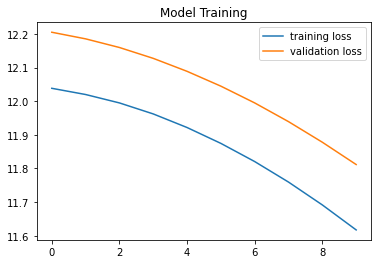

In [ ]:
plt.plot(np.arange(epochs), history.history['loss'], label='training loss')
plt.plot(np.arange(epochs), history.history['val_loss'], label='validation loss')

plt.legend()
_ = plt.title('Model Training')

In [ ]:
# We could have evaluated this on the /data/games_season.csv data
results = regular_season_model.evaluate([X_test['team_1'], X_test['team_2'], 
                                         X_test['home']], y_test,
                               batch_size=128)

732/732 [==============================] - 2s 2ms/step - loss: 11.6856


In [ ]:
tourney_data = pd.read_csv('./data/games_tourney.csv')

regular_season_model.evaluate([tourney_data['team_1'], tourney_data['team_2'],
                               tourney_data['home']],
                     tourney_data['score_diff'], batch_size=128)

34/34 [==============================] - 0s 2ms/step - loss: 11.5600


11.560022354125977

Note that the embedding layer adds a lot of parameters (mapping integers -> floats)

In [ ]:
model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 1)]               0         
                                                                 
 Team-Strength-Lookup (Embed  (None, 1, 1)             10888     
 ding)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 1)                 0         
                                                                 
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


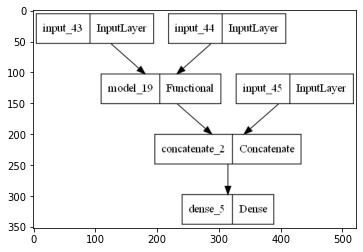

In [ ]:
plot_model(regular_season_model, to_file='./data/model.png')

data = plt.imread('./data/model.png')
plt.imshow(data)

In [ ]:
input_1 = Input(shape=(1, ))
input_2 = Input(shape=(1, ))

multiply_layer = Multiply()([input_1, input_2])

mock_model = Model([input_1, input_2], multiply_layer)

X = np.random.normal(size=(1000, 2))
y = X[:, 0] * X[:, 1]

mock_model.compile(optimizer='sgd', loss='mean_absolute_error')

mock_model.fit([X[:, 0], X[:, 1]], y)

32/32 [==============================] - 0s 2ms/step - loss: 1.9242e-08


In [ ]:
mock_model.predict([np.array([[5]]), np.array([[4]])])

1/1 [==============================] - 0s 57ms/step


array([[20.]], dtype=float32)

### Stacking Models

Stacking models is a technique of building a model which as an input takes in predictions from different model. The datasets on which they are trained should be disjoint. 

In [ ]:
input_tensor = Input(shape=(3,))

output_tensor = Dense(1)(input_tensor)

tourney_model = Model(input_tensor, output_tensor)

tourney_data['pred'] = regular_season_model.predict([tourney_data['team_1'], 
                                                     tourney_data['team_2'], 
                                                     tourney_data['home']])

tourney_model.compile(optimizer='adam', loss='mean_absolute_error')

epochs = 10

tourney_model.fit(tourney_data[['seed_diff', 'home', 'pred']], 
                 tourney_data['score_diff'], 
                 batch_size=256, 
                 validation_split=.1,
                 epochs=epochs)

133/133 [==============================] - 0s 3ms/step
Epoch 1/10
15/15 [==============================] - 1s 23ms/step - loss: 9.2025 - val_loss: 8.8558
Epoch 2/10
15/15 [==============================] - 0s 7ms/step - loss: 9.2016 - val_loss: 8.8547
Epoch 3/10
15/15 [==============================] - 0s 8ms/step - loss: 9.2010 - val_loss: 8.8539
Epoch 4/10
15/15 [==============================] - 0s 7ms/step - loss: 9.2007 - val_loss: 8.8535
Epoch 5/10
15/15 [==============================] - 0s 6ms/step - loss: 9.1999 - val_loss: 8.8525
Epoch 6/10
15/15 [==============================] - 0s 6ms/step - loss: 9.1994 - val_loss: 8.8515
Epoch 7/10
15/15 [==============================] - 0s 6ms/step - loss: 9.1991 - val_loss: 8.8510
Epoch 8/10
15/15 [==============================] - 0s 7ms/step - loss: 9.1985 - val_loss: 8.8501
Epoch 9/10
15/15 [==============================] - 0s 6ms/step - loss: 9.1979 - val_loss: 8.8492
Epoch 10/10
15/15 [==============================] - 0s 6ms/st

### Multi Output Models

We'll build a model which performs classification and regression at the same time. 

In [ ]:
tourney_data.mean()

NameError: name 'tourney_data' is not defined

In [ ]:
input_tensor = Input(shape=(2,))

output_tensor_reg = Dense(1, activation='linear', use_bias=False)(input_tensor)
output_tensor_prob = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_reg)

